In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from datasetcontroller.datacontroller import DataController

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
import time
import numpy as np

2023-06-13 15:11:55.546511: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 15:11:55.582320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 데이터셋 폴더 경로 설정
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# 모델 체크포인트
proj_path = os.path.join(path,'repos','cmaqProject')
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_pixlasso_v1_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 컨트롤러
datacontroller = DataController(data_path = data_path)

# 기본 control matrix, smoke, cmaq 데이터셋 
control_matrix, _, target_arr = datacontroller.get_yearly_dataset()
X_train, X_test, y_train, y_test = train_test_split(control_matrix, target_arr, test_size=0.2, random_state=42 )

#
ctp_names_info = {}
ctp_gpd = datacontroller.get_ctp()
for i in range(len(ctp_gpd)):
    tm = ctp_gpd.loc[i,['CTP_ENG_NM','CTP_KOR_NM']].values
    ctp_names_info[tm[1]] = tm[0]
ctp_names_info['전국'] = 'korea'
ctp_names_info

/usr/local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


{'서울특별시': 'Seoul',
 '부산광역시': 'Busan',
 '대구광역시': 'Daegu',
 '인천광역시': 'Incheon',
 '광주광역시': 'Gwangju',
 '대전광역시': 'Daejeon',
 '울산광역시': 'Ulsan',
 '세종특별자치시': 'Sejong-si',
 '경기도': 'Gyeonggi-do',
 '강원도': 'Gangwon-do',
 '충청북도': 'Chungcheongbuk-do',
 '충청남도': 'Chungcheongnam-do',
 '전라북도': 'Jeollabuk-do',
 '전라남도': 'Jellanam-do',
 '경상북도': 'Gyeongsangbuk-do',
 '경상남도': 'Gyeongsangnam-do',
 '제주특별자치도': 'Jeju-do',
 '전국': 'korea'}

## 기본 텐서플로 알고리즘

In [3]:
from nnmodules.pixbylasso import LassomodPix_v2
import tensorflow as tf

In [4]:
pixlasso = LassomodPix_v2(data_path)
pixlasso.compile()

# 불러오기
checkpoint = tf.train.Checkpoint(
                                 pixlasso=pixlasso,
                                 )

####### 모델 체크포인트 ##########
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=120)
checkpoint.restore(manager.latest_checkpoint)

2023-06-13 09:35:57.776283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22010 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6
/usr/local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/nnmodules/pixbylasso.py:44: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


CPU times: user 2min 10s, sys: 3.83 s, total: 2min 13s
Wall time: 2min 13s


<Axes: >

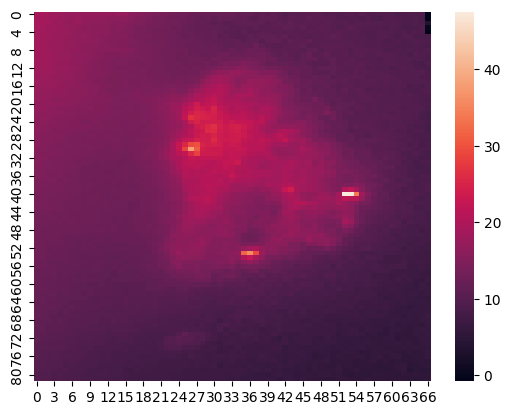

In [5]:
%%time
pred = pixlasso(X_train)
sns.heatmap(pred[0,:,:,0][::-1])

In [6]:
%%time
def train_step_fine(pix_index, input,target, x, y, optimizer):
    with tf.GradientTape() as tape:
        output = pixlasso.grid_layers[pix_index](input)
        sub_target = target[:,x,y,:]
        l1_loss = pixlasso.lose_mse(sub_target, output)
    
    gradients = tape.gradient(l1_loss, pixlasso.grid_layers[pix_index].trainable_variables)
    optimizer.apply_gradients(zip(gradients, pixlasso.grid_layers[pix_index].trainable_variables))
    return l1_loss

epochs = 5000
early_stop_n = 100
down_lr_epoch = 500
down_lr_ratio = 0.1

# for i, pix_index in enumerate(pixlasso._indexed_grid_point.index.tolist()[:2490]):
for i, pix_index in enumerate(pixlasso._indexed_grid_point.loc[pixlasso._indexed_grid_point.CTP_KOR_NM == '경상북도'].index.tolist()):
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(lr)
    stop_count = 0
    x, y = pix_index%82,pix_index//82

    #저장
    if (i + 1) % 500 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    start_time = time.time()
    for epoch in range(epochs):

        # reset lr for fine tune
        if epoch != 0 and epoch % down_lr_epoch == 0:
            lr = lr * down_lr_ratio
            optimizer = tf.keras.optimizers.Adam(lr)


        l1_loss = train_step_fine(pix_index, X_train,y_train, x, y, optimizer)

        # set early stop
        if epoch != 0 and l1_loss_before <= l1_loss:
            stop_count += 1
            
        if stop_count == early_stop_n:
            print(f"\rGrid {pix_index} Epoch {epoch}/ loss: {l1_loss:.4f} / time: {time.time() - start_time:.2f} sec / early_stoped", end="")
            break

        l1_loss_before = l1_loss

        print(f"\rGrid {pix_index} Epoch {epoch}/ loss: {l1_loss:.4f} / time: {time.time() - start_time:.2f} sec", end="")
        ## print()

Grid 4552 Epoch 2204/ loss: 0.8178 / time: 13.97 sec / early_stopedCPU times: user 57min 32s, sys: 57.6 s, total: 58min 29s
Wall time: 54min 7s


<Axes: >

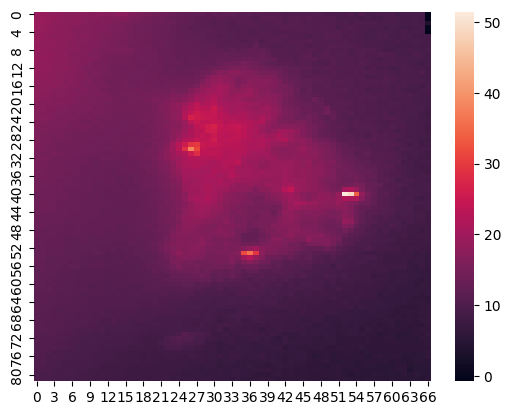

In [7]:
pred2 = pixlasso(X_train)
sns.heatmap(pred2[0,:,:,0][::-1])

In [8]:
%%time
pred_train = pixlasso(X_train)
pred_test = pixlasso(X_test)

CPU times: user 6.25 s, sys: 166 ms, total: 6.42 s
Wall time: 5.02 s


In [9]:
from sklearn.metrics import mean_squared_error, r2_score

mse_train = mean_squared_error(pred_train.numpy().reshape(-1), y_train.reshape(-1))
rmse_train = mse_train**0.5
r2_train = r2_score(pred_train.numpy().reshape(-1), y_train.reshape(-1))

mse_test = mean_squared_error(pred_test.numpy().reshape(-1), y_test.reshape(-1))
rmse_test = mse_test**0.5
r2_test = r2_score(pred_test.numpy().reshape(-1), y_test.reshape(-1))

print(f'trainset / mse: {mse_train} / rmse: {rmse_train} / r2: {r2_train}')
print(f'testset / mse: {mse_test} / rmse: {rmse_test} / r2: {r2_test}')

trainset / mse: 0.38646821280361243 / rmse: 0.621665676070034 / r2: 0.9776849694231335
testset / mse: 0.39524700134734275 / rmse: 0.6286867275100873 / r2: 0.9772114652533636


Text(0, 0.5, 'Normalized Mean Error (NME %)')

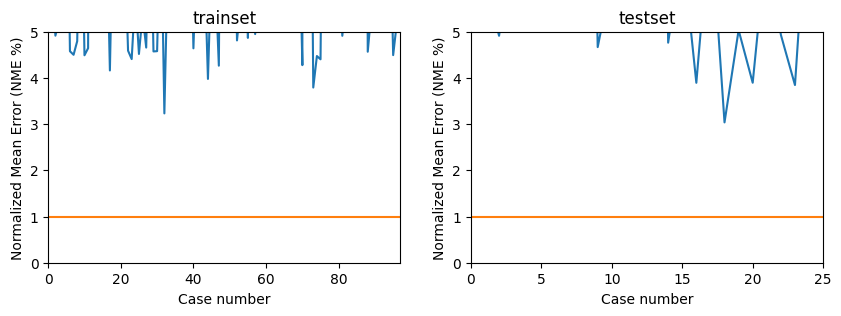

In [10]:
# In[]
def NME(y_true, y_pred):
    return np.sum( abs( (y_pred - y_true) / y_true ) ) / len(y_pred)

result_test = []                                                                                                                                                                                                                                                                                                      
for i in range(len(X_test)):
    result_test.append(NME(pred_test[i][::-1].numpy().reshape(-1), y_test[i][::-1].reshape(-1)))

result_train = []                                                                                                                                                                                                                                                                                                              
for i in range(len(X_train)):
    result_train.append(NME(pred_train[i][::-1].numpy().reshape(-1), y_train[i][::-1].reshape(-1)))

#
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(np.arange(1,len(X_train)+1,1), np.array(result_train) * 100)
plt.xlim([0,len(X_train)+1])
plt.ylim([0,5])
plt.plot([0,len(X_train)+1],[1,1])
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(np.arange(1,len(X_test)+1,1), np.array(result_test) * 100)
plt.xlim([0,len(X_test)+1])
plt.ylim([0,5])
plt.plot([0,len(X_test)+1],[1,1])
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')

Text(0, 0.5, 'target')

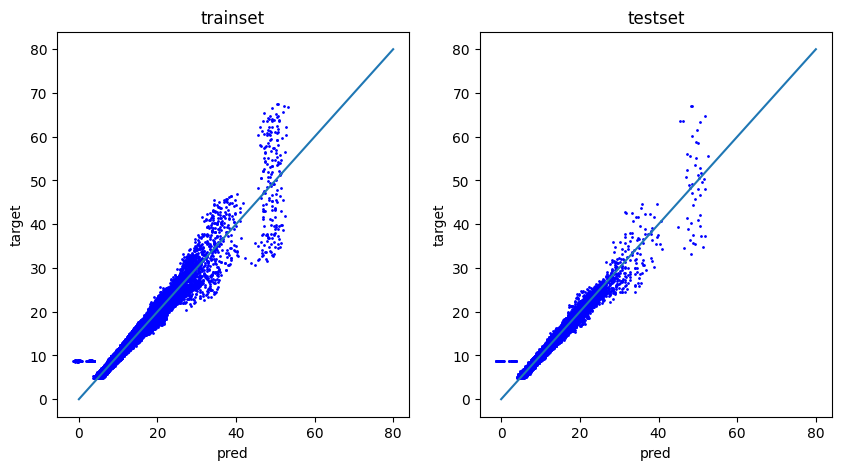

In [11]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(pred_train.numpy().reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(pred_test.numpy().reshape(-1), y_test.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

** 경북만 피팅

In [12]:
pixlasso_2 = LassomodPix_v2(data_path)
pixlasso_2.compile()

/usr/local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/nnmodules/pixbylasso.py:44: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


In [ ]:
%%time
def train_step_fine(pix_index, input,target, x, y, optimizer):
    with tf.GradientTape() as tape:
        output = pixlasso_2.grid_layers[pix_index](input)
        sub_target = target[:,x,y,:]
        l1_loss = pixlasso_2.lose_mse(sub_target, output)
    
    gradients = tape.gradient(l1_loss, pixlasso_2.grid_layers[pix_index].trainable_variables)
    optimizer.apply_gradients(zip(gradients, pixlasso_2.grid_layers[pix_index].trainable_variables))
    return l1_loss

epochs = 5000
early_stop_n = 100
down_lr_epoch = 500
down_lr_ratio = 0.1

for i, pix_index in enumerate(pixlasso_2._indexed_grid_point.index.tolist()[:2490]):
# for i, pix_index in enumerate(pixlasso_2._indexed_grid_point.loc[pixlasso_2._indexed_grid_point.CTP_KOR_NM == '경상북도'].index.tolist()):
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(lr)
    stop_count = 0
    x, y = pix_index%82,pix_index//82

    #저장
    if (i + 1) % 500 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    start_time = time.time()
    for epoch in range(epochs):

        # reset lr for fine tune
        if epoch != 0 and epoch % down_lr_epoch == 0:
            lr = lr * down_lr_ratio
            optimizer = tf.keras.optimizers.Adam(lr)


        l1_loss = train_step_fine(pix_index, X_train,y_train, x, y, optimizer)

        # set early stop
        if epoch != 0 and l1_loss_before <= l1_loss:
            stop_count += 1
            
        if stop_count == early_stop_n:
            print(f"\rGrid {pix_index} Epoch {epoch}/ loss: {l1_loss:.4f} / time: {time.time() - start_time:.2f} sec / early_stoped", end="")
            break

        l1_loss_before = l1_loss

        print(f"\rGrid {pix_index} Epoch {epoch}/ loss: {l1_loss:.4f} / time: {time.time() - start_time:.2f} sec", end="")
        ## print()

<Axes: >

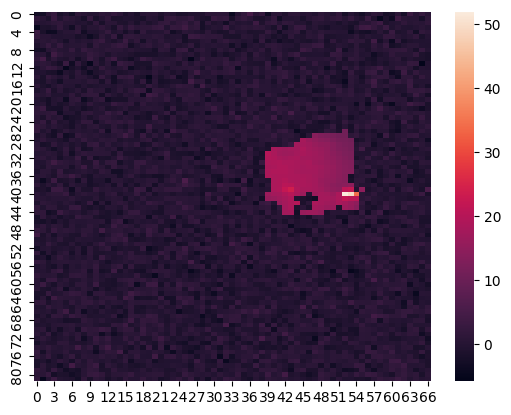

In [20]:
pred2 = pixlasso_2(X_train)
sns.heatmap(pred2[0,:,:,0][::-1])

<Axes: >

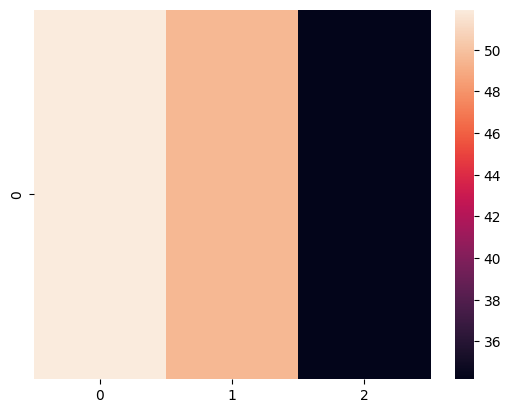

In [35]:
sns.heatmap(pred2[0,41:42,52:55,0][::-1])

In [17]:
%%time
pred_train = pixlasso_2(X_train)
pred_test = pixlasso_2(X_test)

CPU times: user 6.3 s, sys: 98.4 ms, total: 6.4 s
Wall time: 5 s


Text(0, 0.5, 'target')

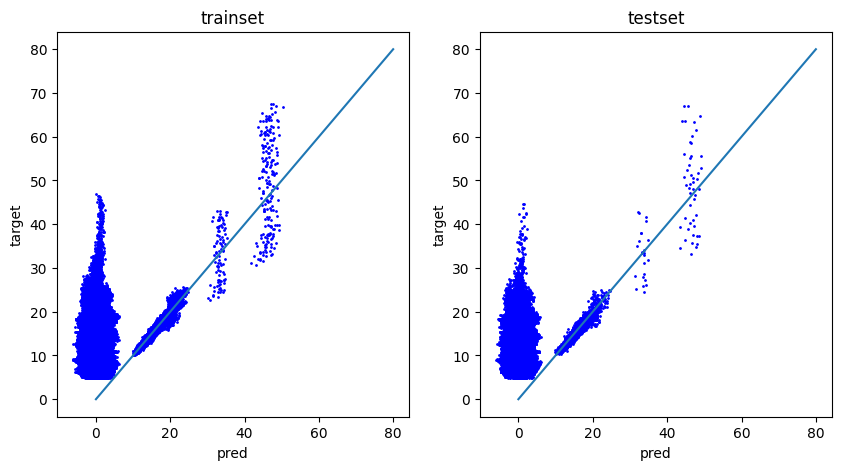

In [18]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(pred_train.numpy().reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(pred_test.numpy().reshape(-1), y_test.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

CPU times: user 6.35 s, sys: 95.6 ms, total: 6.45 s
Wall time: 5.03 s


Text(0, 0.5, 'target')

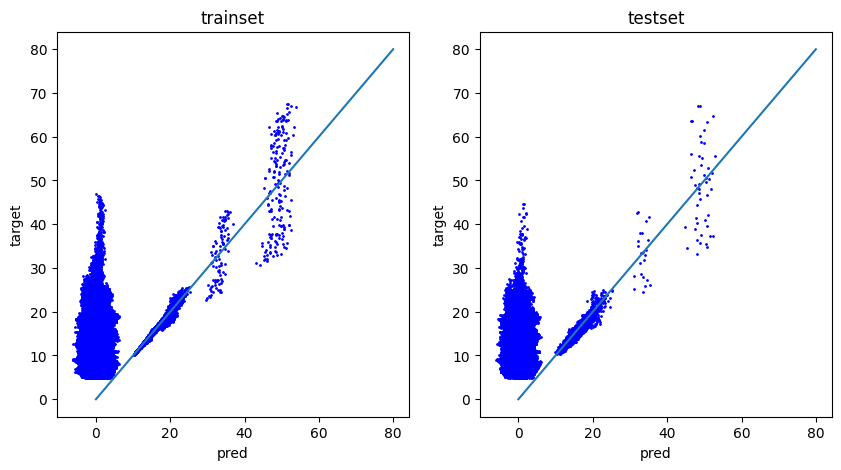

In [21]:
%%time
pred_train = pixlasso_2(X_train)
pred_test = pixlasso_2(X_test)
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(pred_train.numpy().reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(pred_test.numpy().reshape(-1), y_test.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

In [ ]:
%%time
pred_train = pixlasso_2(X_train)
pred_test = pixlasso_2(X_test)
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(pred_train.numpy().reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(pred_test.numpy().reshape(-1), y_test.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

In [37]:
%%time
def train_step_fine(pix_index, input,target, x, y, optimizer):
    with tf.GradientTape() as tape:
        output = pixlasso_2.grid_layers[pix_index](input)
        sub_target = target[:,x,y,:]
        l1_loss = pixlasso_2.lose_mse(sub_target, output)
    
    gradients = tape.gradient(l1_loss, pixlasso_2.grid_layers[pix_index].trainable_variables)
    optimizer.apply_gradients(zip(gradients, pixlasso_2.grid_layers[pix_index].trainable_variables))
    return l1_loss

epochs = 100000
early_stop_n = 100
down_lr_epoch = 500
down_lr_ratio = 0.1

pixlasso_2 = LassomodPix_v2(data_path)
pixlasso_2.compile()
# 41:42,52:55
# for i, pix_index in enumerate(pixlasso_2._indexed_grid_point.index.tolist()[:2490]):
for i, pix_index in enumerate(pixlasso_2._indexed_grid_point.loc[pixlasso_2._indexed_grid_point.CTP_KOR_NM == '경상북도'].index.tolist()):

        lr = 0.001
        optimizer = tf.keras.optimizers.Adam(lr)
        stop_count = 0
        x, y = pix_index%82,pix_index//82
        if x == 41 and y == 52:
            # continue

            # pix_index = x*82 + y

            # #저장
            # if (i + 1) % 500 == 0:
            #     checkpoint.save(file_prefix=checkpoint_prefix)

            start_time = time.time()
            for epoch in range(epochs):

                # reset lr for fine tune
                if epoch != 0 and epoch % down_lr_epoch == 0:
                    lr = lr * down_lr_ratio
                    optimizer = tf.keras.optimizers.Adam(lr)

                ind = np.random.choice(range(len(X_train)), 80)
                l1_loss = train_step_fine(pix_index, X_train[ind],y_train[ind], x, y, optimizer)

                # # set early stop
                # if epoch != 0 and l1_loss_before <= l1_loss:
                #     stop_count += 1
                    
                # if stop_count == early_stop_n:
                #     # print(f"\rGrid {pix_index} Epoch {epoch}/ loss: {l1_loss:.4f} / time: {time.time() - start_time:.2f} sec / early_stoped", end="")
                #     print(f"\r{x}, {y}, {l1_loss}", end="")
                #     break

                l1_loss_before = l1_loss
                print(f"\r{x}, {y}, {l1_loss}--{epoch}", end="")
                # print(f"\rGrid {pix_index} Epoch {epoch}/ loss: {l1_loss:.4f} / time: {time.time() - start_time:.2f} sec", end="")
                ## print()

41, 52, 139.23971557617188--99999CPU times: user 11min 43s, sys: 10.6 s, total: 11min 53s
Wall time: 11min 4s


CPU times: user 24.4 s, sys: 719 ms, total: 25.1 s
Wall time: 21.8 s


Text(0, 0.5, 'target')

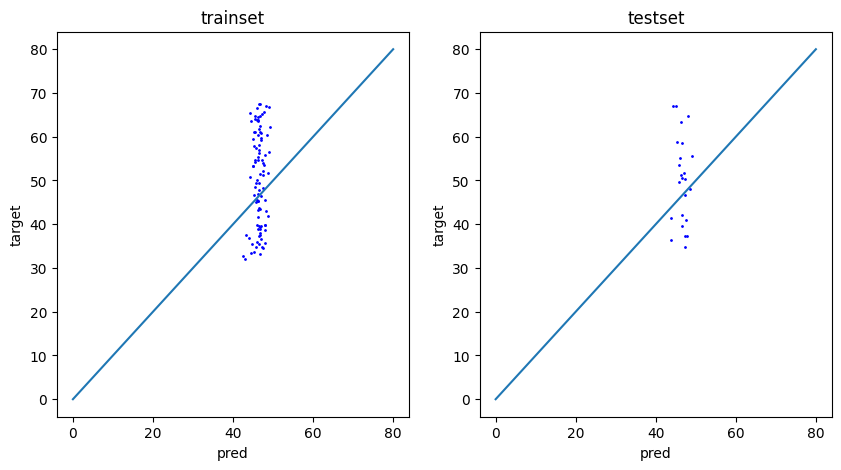

In [38]:
%%time
pred_train = pixlasso_2(X_train)
pred_test = pixlasso_2(X_test)
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(pred_train.numpy()[:,41:42,52:53,:].reshape(-1), y_train[:,41:42,52:53,:].reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(pred_test.numpy()[:,41:42,52:53,:].reshape(-1), y_test[:,41:42,52:53,:].reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

<Axes: >

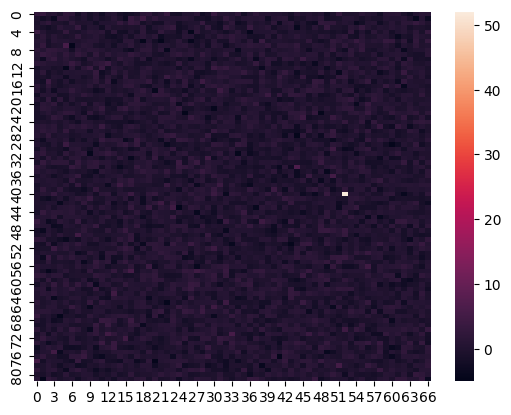

In [9]:
pred2 = pixlasso_2(X_train)
sns.heatmap(pred2[0,:,:,0][::-1])

* jax

In [14]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
from jax import grad, jit, vmap
from jax import random
import optax

In [35]:
@jax.jit
def lasso_loss(params, x_batched, y_batched):
    
    model  = nn.Dense(features=1, kernel_init=nn.initializers.xavier_uniform())
    def squared_error(x, y):
        pred = model.apply(params, x)
        return jnp.inner(y-pred, y-pred) / 2.0

    mse_loss = jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)
    l1_loss = jnp.sum(jnp.abs(params['params']['kernel']))

    # Vectorize the previous to compute the average of the loss on all samples.
    return 0.01 * l1_loss + mse_loss
        
        
loss_grad_fn = jax.value_and_grad(lasso_loss)
model  = nn.Dense(features=1, kernel_init=nn.initializers.xavier_uniform())
key = random.PRNGKey(0)
input_dim = X_train.shape[1]
output_dim = 1
params = model.init(key, jnp.ones((1, input_dim)))

lr = 0.001
tx = optax.adam(learning_rate=lr)
opt_state = tx.init(params)
for i in range(10000):
    
    ind = np.random.choice(range(len(X_train)), 80)
    inputs, targets = X_train[ind] ,y_train[ind][:,41,52,:]

    
    loss_val, grads = loss_grad_fn(params, inputs, targets)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    print(f'\r{i}--{loss_val}', end="")

9999--20.983283996582035

Text(0, 0.5, 'target')

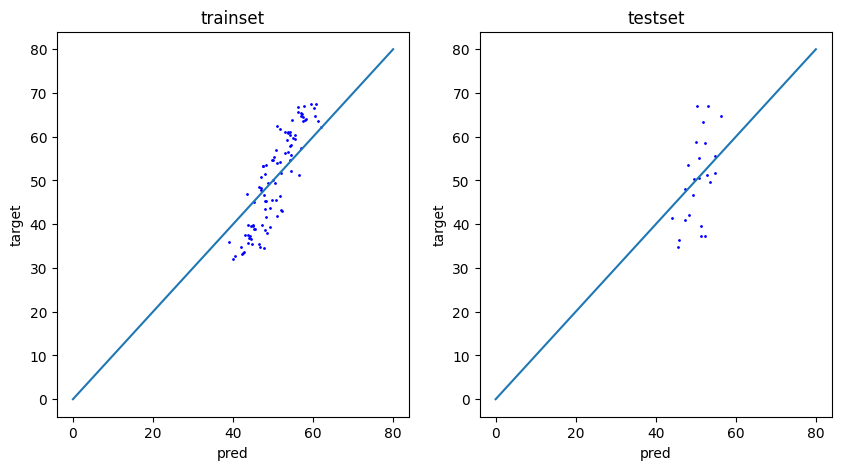

In [36]:
pred_train = model.apply(params, X_train)
pred_test = model.apply(params, X_test)
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(pred_train.reshape(-1), y_train[:,41:42,52:53,:].reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(pred_test.reshape(-1), y_test[:,41:42,52:53,:].reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')